In [19]:
import os
import numpy as np
# import pandas as pd
import pickle
import shutil
from collections import Counter
import matplotlib.pyplot as plt
from graph_tool import clustering as clst
# from reportlab.pdfgen import canvas
from PyPDF2 import PdfFileWriter, PdfFileReader
from typing import *
import json
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
import warnings


In [ ]:
from graph_tool.all import *

# Subgraphs by annotation label analysis and visualization

## simple motifs, no structural attributes

In [3]:
all_motifs_type_colors = {}

In [4]:
def remove_duplicate_motifs(motifs, motifs_cnts):
    new_motifs = {}
    for motif1, motif1_cnts in zip(motifs, motifs_cnts):
        in_flag = False
        for motif2, motif2_cnts in new_motifs.items():
            if isomorphism(motif1, motif2) and motif1 is not motif2:
                in_flag = True
                new_motifs[motif1]+=motif2_cnts
                
        if not in_flag:
            new_motifs[motif1] = motif1_cnts

    return list(new_motifs.keys()), list(new_motifs.values())


def calc_motifs_no_redundant_edges(g, motifs_len, name_to_save_by=None, dir_to_save_path=None):
    remove_parallel_edges(g)
    motifs, motifs_cnts, motifs_vertex_properties = clst.motifs(g, k=motifs_len, p=1.0, return_maps=True)
    motifs, motifs_cnts = remove_duplicate_motifs(motifs, motifs_cnts)
    motifs_dict = {
        motif: {'motif_count': cnt, 'motif_vertex_ids': single_motif_v_ids} \
        for motif, cnt, single_motif_v_ids in zip(motifs, motifs_cnts, motifs_vertex_properties)
    }
    
    if name_to_save_by is None:
        return motifs_dict
    
    if dir_to_save_path is not None:
        path_to_save_motifs_data = os.path.join(dir_to_save_path, name_to_save_by)
    else:
        path_to_save_motifs_data = name_to_save_by
    
    with open(path_to_save_motifs_data, 'wb') as f:
        pickle.dump(motifs_dict, f)
    
    return motifs_dict

def get_flag(motif_type, v_color):
    graph_draw(motif_type, output='tmp/t.png', output_size=(30, 30), vertex_fill_color=v_color)
    path = "tmp/t.png"
    im = plt.imread(path)
    return im

def offset_image(coord, motif_type, ax):
    v_color = all_motifs_type_colors[motif_type]
    img = get_flag(motif_type, v_color=v_color)
    im = OffsetImage(img, zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -16.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)
    
def plot_motif_cnts_per_type(motifs_types, valuesA, subgraph_name, path_to_save_plot_dir = None, motifs_len: int =4):
    """
    plots with motifs ilustration (graph_draw) as axis labels
    """
    fig, ax = plt.subplots(figsize=(30, 20))

    ax.bar(range(len(motifs_types)), valuesA, width=0.5, align="center")
    ax.set_xticks(range(len(motifs_types)))
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='major', pad=26)
    
    for bars in ax.containers:
        ax.bar_label(bars)   
        
    ax.set_title(f"{subgraph_name} counts")
    
#     plt.tight_layout()
    
    for i, motif_type in enumerate(motifs_types):
        offset_image(i, motif_type, ax)
    if path_to_save_plot_dir is None:
        plt.show()
    else:
        path_to_save_plot = os.path.join(path_to_save_plot_dir, f"{subgraph_name}_{motifs_len}.png")
        plt.savefig(path_to_save_plot, dpi=300)
        
def draw_graph_with_motifs_coloring(g, motifs_len, name_to_save_by, dir_to_save_path=None, 
                                    motifs_precalculated_dict_pickle_path: str= None):
    global all_motifs_type_colors
#     use pre calculated motifs distributions
    if motifs_precalculated_dict_pickle_path is not None:
        with open(motifs_precalculated_dict_pickle_path, 'rb') as f:
            data = pickle.load(f)
            motifs = data.keys()
            motifs_cnts, motifs_vertex_properties = [], []
            for motif in motifs:
                motifs_cnts.append(data[motif]['motif_count'])
                motifs_vertex_properties.append(data[motif]['motif_vertex_ids'])
    else:
        #     calculate motifs and aggregate all motifs vertices_ids
        motifs_dict = calc_motifs_no_redundant_edges(g, motifs_len)
        motifs, motifs_cnts, motifs_vertex_properties = [], [], []
        for motif, motif_vals in motifs_dict.items():
            motifs.append(motif)
            motifs_cnts.append(motif_vals['motif_count'])
            motifs_vertex_properties.append(motif_vals['motif_vertex_ids'])
    
    all_motifs_type_v_ids = {}
    for motif, motifs_v_ids in zip(motifs, motifs_vertex_properties): 
        single_motif_type_v_ids = []
        for single_motif_v_ids in motifs_v_ids:
            if any([type(x) is not int for x in single_motif_v_ids.a.tolist()]):
                raise Exception(f"Vertices IDs must be integers only;\n{single_motif_v_ids.a.tolist()}, {[type(x) for x in single_motif_v_ids.a.tolist()]}")
            single_motif_type_v_ids+=single_motif_v_ids.a.tolist()
        all_motifs_type_v_ids[motif] = single_motif_type_v_ids 
#         if motif type is not familiar, set up a random color, if already seen, we will use the color already assigned
        if all_motifs_type_colors.get(motif, None) is None:
            motif_type_color = list(np.random.choice(np.arange(0.3, 1., 0.1), size=3)) + [0.9]
            all_motifs_type_colors[motif] = motif_type_color
    
    g_positions = g.vp['coordinates']
    vprop_vcolor_by_motif = g.new_vertex_property("vector<double>")
#     create the color mapping for each vertex (GT propertyMap) and collect vertices coordinates
    for motif, motif_v_ids in all_motifs_type_v_ids.items():
        motif_color = all_motifs_type_colors[motif]
        for v_id in motif_v_ids:
            v = g.vertex(v_id)
            vprop_vcolor_by_motif[v_id] = motif_color
    
#     # create the color mapping for each edge (GT propertyMap)
#     eprop_ecolor_by_motif = g.new_edge_property("vector<double>")
#     for motif, motif_v_ids in all_motifs_type_v_ids.items():
#         motif_color = all_motifs_type_colors[motif]
#         for v_id in motif_v_ids:
#             v = g.vertex(v_id)
#             for edge in g.iter_all_edges(v):
#                 edge = tuple(edge)
#                 print("#"*20, "\n", f"{edge}\n","#"*20)
#                 eprop_ecolor_by_motif[edge] = motif_color

    # fill property map for vertices not in motifs:
    changed_ctr = 0
    for v in g.iter_vertices():
        if not len(vprop_vcolor_by_motif[v]):
#     assigned black color to all vertices within the subgraph that do not belong to a motif
            vprop_vcolor_by_motif[v] = [0., 0., 0., 1.]
    
#     # fill property map for edges not in motifs:
#     changed_ctr = 0
#     for v in g.iter_edges():
#         if not len(vprop_vcolor_by_motif[v]):
# #     assigned black color to all edges within the subgraph that do not belong to a motif
#             eprop_ecolor_by_motif[edge] = [0., 0., 0., 1.]
    
    
    output_fname = f"{name_to_save_by}_with_motif_{motifs_len}.pdf"
    output_dir_name = f"{name_to_save_by}" 
    dir_to_save_path_by_subgraph = os.path.join(dir_to_save_path, output_dir_name)
    
    if not os.path.isdir(dir_to_save_path_by_subgraph):
        os.makedirs(dir_to_save_path_by_subgraph)
    
    output_path = os.path.join(dir_to_save_path_by_subgraph, output_fname)
    graph_draw(g, pos=g_positions, output=output_path,
               vertex_fill_color=vprop_vcolor_by_motif,)
#                edge_color=eprop_ecolor_by_motif)
    
    output_fname = output_fname.replace('.pdf', '.png')
#     output_path = os.path.join(dir_to_save_path_by_subgraph, output_fname)
    if len(motifs) > 10:
        index = 0
        for i1, i2 in zip(range(0, len(motifs), 10), range(10, len(motifs)+9, 10)):
            motifs_tmp, motifs_cnts_tmp = motifs[i1:i2], motifs_cnts[i1:i2]
            output_fname_tmp = output_fname.replace('.png', f'_{index}.png')
            plot_motif_cnts_per_type(motifs_types=motifs_tmp, valuesA=motifs_cnts_tmp, 
                                     subgraph_name=output_fname_tmp, 
                                     path_to_save_plot_dir=dir_to_save_path_by_subgraph, 
                                     motifs_len=motifs_len)
            index += 1
    else:
        plot_motif_cnts_per_type(motifs_types=motifs, valuesA=motifs_cnts, 
                                 subgraph_name=output_fname, 
                                 path_to_save_plot_dir=dir_to_save_path_by_subgraph, 
                                 motifs_len=motifs_len)

def find_motifs_no_redundant_edges(g, motif_len, name_to_save_by=None, dir_to_save_path=None, motifs_precalculated_dict_pickle_path=None):
    remove_parallel_edges(g)
    draw_graph_with_motifs_coloring(g, motif_len, name_to_save_by, dir_to_save_path, motifs_precalculated_dict_pickle_path)
    

In [12]:
motifs_len = 4
graph_size_lim = 10**5 if motifs_len <= 6 else 10**4

### calc motifs distributions

In [ ]:
subgraphs_dir = '/scratch/mice_subgraphs/subgraphsByAnnotationLabels'
to_save_distributions_dir_path = f'/scratch/motifsDistributions/MotifDistributionsPerAnnotationPickled/MotifSize_{motifs_len}'

if not os.path.isdir(to_save_distributions_dir_path):
    os.makedirs(to_save_distributions_dir_path, exist_ok=True)

subgraphs_names = os.listdir(subgraphs_dir)

all_subgraphs_motifs_data = {}
for subgraph_name in subgraphs_names[:]:
    print(subgraph_name)    
    subgraph_path = os.path.join(subgraphs_dir, subgraph_name)
    subgraph_gt = load_graph(subgraph_path)
    if subgraph_gt.num_vertices() > graph_size_lim:
        continue
    all_subgraphs_motifs_data[subgraph_name] = calc_motifs_no_redundant_edges(subgraph_gt, motifs_len, subgraph_name, to_save_distributions_dir_path)



subgraph_area_vestibular nerve.gt
subgraph_area_Inferior colliculus.gt
subgraph_area_Olfactory areas.gt
subgraph_area_Culmen.gt
subgraph_area_motor root of the trigeminal nerve.gt
subgraph_area_Pyramus (VIII).gt
subgraph_area_lateral lemniscus.gt
subgraph_area_Simple lobule.gt
subgraph_area_universe.gt
subgraph_area_Midbrain reticular nucleus, retrorubral area.gt
subgraph_area_mammillotegmental tract.gt
subgraph_area_lateral ventricle.gt
subgraph_area_spinal tract of the trigeminal nerve.gt
subgraph_area_Trochlear nucleus.gt
subgraph_area_Ansiform lobule.gt
subgraph_area_Lingula (I).gt
subgraph_area_Basic cell groups and regions.gt
subgraph_area_cerebal peduncle.gt
subgraph_area_Parabigeminal nucleus.gt
subgraph_area_Midbrain.gt
subgraph_area_Flocculus.gt
subgraph_area_arbor vitae.gt
subgraph_area_Declive (VI).gt
subgraph_area_habenular commissure.gt
subgraph_area_Substantia nigra, compact part.gt
subgraph_area_inferior colliculus commissure.gt
subgraph_area_Copula pyramidis.gt
subgrap

## calc motif z score significance

In [41]:
def is_isomorphic_motif(motif_1, motif2_group):
    for motif2 in motif2_group:
        if isomorphism(motif1, motif2):
            return True
    return False
                
def calc_motif_z_score(motif_n_target: int, motif_n_random_networks: np.array, significance_threshold: float = 2.0):
    random_sigma = motif_n_random_networks.std()
    z_score = (motif_n_target - motif_n_random_networks.mean())/random_sigma
    is_significant = z_score > significance_threshold
    return z_score, is_significant


def rewire_subgraph_and_calc_motifs_of_random(subgraph, motifs_len_to_compare:int = 4, **kwargs):
    subgraph_to_shuffle = subgraph.copy()
    random_rewire(subgraph_to_shuffle, model=kwargs.get('shuffle_model', 'configuration'),
                  n_iter=kwargs.get('shuffle_iters', 1),
                  edge_sweep=kwargs.get('shuffle_edge_sweep', True),
                  parallel_edges=kwargs.get('shuffle_parallel_edges', False))
    shuffled_motif_dist = calc_motifs_no_redundant_edges(subgraph_to_shuffle, motifs_len_to_compare)
    return shuffled_motif_dist

def motifs_z_scores_calculation(org_graph, 
                                org_graph_motifs_dict, 
                                motifs_len_to_compare:int = 4, 
                                n_random_graphs_to_generate: int = 1000, 
                                **kwargs):
    graph_cpy = org_graph.copy()
    motifs_counts_in_random_graph = {}
    print(f'Started generating {n_random_graphs_to_generate} random graphs:')
    for i in range(n_random_graphs_to_generate):
        print(f'Generating random graph {i+1}/{n_random_graphs_to_generate}')
        rand_graph_motifs_dist = rewire_subgraph_and_calc_motifs_of_random(graph_cpy, 
                                                                           motifs_len_to_compare, 
                                                                           **kwargs)
        for motif, motif_dict in rand_graph_motifs_dist.items():
            motifs_counts_in_random_graph[motif] = motifs_counts_in_random_graph.get(motif, []) + [motif_dict['motif_count']]
    print(f'Started calculating motifs z-scores:')
    motifs_z_scores = {}
    for motif, motif_dict in motifs_counts_in_random_graph.items():
        motif_n_target = None
        for org_motif in org_graph_motifs_dict.keys():
            if isomorphism(org_motif, motif):
                motif_n_target = org_graph_motifs_dict[org_motif]['motif_count']
        if motif_n_target is None:
            warnings.warn(f"Motif {motif} was not found in the original graph, skipping")
            continue
        motif_counts_in_random_network_nparray = np.array(motifs_counts_in_random_graph[motif])
        motifs_z_scores[motif] = calc_motif_z_score(motif_n_target=motif_n_target,
                                                    motif_n_random_networks=motif_counts_in_random_network_nparray,
                                                   significance_threshold=kwargs.get('z_score_significance_threshold', 2))
    return motifs_z_scores
        

### examples for z-score significance calculation for Ph.D. proposal

In [15]:
motifs_len = 4
precalc_pickled_distributions_dir_path = f'/scratch/motifsDistributions/MotifDistributionsPerAnnotationPickled/MotifSize_{motifs_len}'
subgraphs_dir = '/scratch/mice_subgraphs/subgraphsByAnnotationLabels'
all_subgraphs_in_dir = os.listdir(subgraphs_dir)
phd_prop_subgraphs_names = list(filter(lambda subgraph_name: 
                                 any([target_name.lower() in subgraph_name.lower() for target_name in ('Cuneiform Nucleus', 'Fasciculus Retroflexus')]), 
                                      all_subgraphs_in_dir))
phd_prop_subgraphs_paths = list(map(lambda x: os.path.join(subgraphs_dir, x), phd_prop_subgraphs_names))
phd_prop_subgraphs_gt = {sub_name: load_graph(sub_path) for sub_name, sub_path in 
                         zip(phd_prop_subgraphs_names, phd_prop_subgraphs_paths)} 

In [17]:
subgraphs_motifs = {}
subgraphs_motifs_stats = {}

for sub_name, sub_gt in phd_prop_subgraphs_gt.items():
    subgraphs_motifs[sub_name] = calc_motifs_no_redundant_edges(g=sub_gt, motifs_len=motifs_len)

In [43]:
subgraph_motifs_zscores = {}
for sub_name, sub_motifs_dict in subgraphs_motifs.items():
    subgraph_motifs_zscores[sub_name] = {}
    subgraph_motifs_zscores[sub_name]['motifs_zscores'] = motifs_z_scores_calculation(
        org_graph=phd_prop_subgraphs_gt[sub_name], 
        org_graph_motifs_dict=sub_motifs_dict, 
        motifs_len_to_compare=4, 
        n_random_graphs_to_generate=1000,
        z_score_significance_threshold=2.0
    )
    
    

Started generating 1000 random graphs:
Generating random graph 1/1000
Generating random graph 2/1000
Generating random graph 3/1000
Generating random graph 4/1000
Generating random graph 5/1000
Generating random graph 6/1000
Generating random graph 7/1000
Generating random graph 8/1000
Generating random graph 9/1000
Generating random graph 10/1000
Generating random graph 11/1000
Generating random graph 12/1000
Generating random graph 13/1000
Generating random graph 14/1000
Generating random graph 15/1000
Generating random graph 16/1000
Generating random graph 17/1000
Generating random graph 18/1000
Generating random graph 19/1000
Generating random graph 20/1000
Generating random graph 21/1000
Generating random graph 22/1000
Generating random graph 23/1000
Generating random graph 24/1000
Generating random graph 25/1000
Generating random graph 26/1000
Generating random graph 27/1000
Generating random graph 28/1000
Generating random graph 29/1000
Generating random graph 30/1000
Generating

Generating random graph 254/1000
Generating random graph 255/1000
Generating random graph 256/1000
Generating random graph 257/1000
Generating random graph 258/1000
Generating random graph 259/1000
Generating random graph 260/1000
Generating random graph 261/1000
Generating random graph 262/1000
Generating random graph 263/1000
Generating random graph 264/1000
Generating random graph 265/1000
Generating random graph 266/1000
Generating random graph 267/1000
Generating random graph 268/1000
Generating random graph 269/1000
Generating random graph 270/1000
Generating random graph 271/1000
Generating random graph 272/1000
Generating random graph 273/1000
Generating random graph 274/1000
Generating random graph 275/1000
Generating random graph 276/1000
Generating random graph 277/1000
Generating random graph 278/1000
Generating random graph 279/1000
Generating random graph 280/1000
Generating random graph 281/1000
Generating random graph 282/1000
Generating random graph 283/1000
Generating

Generating random graph 505/1000
Generating random graph 506/1000
Generating random graph 507/1000
Generating random graph 508/1000
Generating random graph 509/1000
Generating random graph 510/1000
Generating random graph 511/1000
Generating random graph 512/1000
Generating random graph 513/1000
Generating random graph 514/1000
Generating random graph 515/1000
Generating random graph 516/1000
Generating random graph 517/1000
Generating random graph 518/1000
Generating random graph 519/1000
Generating random graph 520/1000
Generating random graph 521/1000
Generating random graph 522/1000
Generating random graph 523/1000
Generating random graph 524/1000
Generating random graph 525/1000
Generating random graph 526/1000
Generating random graph 527/1000
Generating random graph 528/1000
Generating random graph 529/1000
Generating random graph 530/1000
Generating random graph 531/1000
Generating random graph 532/1000
Generating random graph 533/1000
Generating random graph 534/1000
Generating

Generating random graph 754/1000
Generating random graph 755/1000
Generating random graph 756/1000
Generating random graph 757/1000
Generating random graph 758/1000
Generating random graph 759/1000
Generating random graph 760/1000
Generating random graph 761/1000
Generating random graph 762/1000
Generating random graph 763/1000
Generating random graph 764/1000
Generating random graph 765/1000
Generating random graph 766/1000
Generating random graph 767/1000
Generating random graph 768/1000
Generating random graph 769/1000
Generating random graph 770/1000
Generating random graph 771/1000
Generating random graph 772/1000
Generating random graph 773/1000
Generating random graph 774/1000
Generating random graph 775/1000
Generating random graph 776/1000
Generating random graph 777/1000
Generating random graph 778/1000
Generating random graph 779/1000
Generating random graph 780/1000
Generating random graph 781/1000
Generating random graph 782/1000
Generating random graph 783/1000
Generating

/tmp/ipykernel_303720/331332085.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = (motif_n_target - motif_n_random_networks.mean())/random_sigma


Started generating 1000 random graphs:
Generating random graph 1/1000
Generating random graph 2/1000
Generating random graph 3/1000
Generating random graph 4/1000
Generating random graph 5/1000
Generating random graph 6/1000
Generating random graph 7/1000
Generating random graph 8/1000
Generating random graph 9/1000
Generating random graph 10/1000
Generating random graph 11/1000
Generating random graph 12/1000
Generating random graph 13/1000
Generating random graph 14/1000
Generating random graph 15/1000
Generating random graph 16/1000
Generating random graph 17/1000
Generating random graph 18/1000
Generating random graph 19/1000
Generating random graph 20/1000
Generating random graph 21/1000
Generating random graph 22/1000
Generating random graph 23/1000
Generating random graph 24/1000
Generating random graph 25/1000
Generating random graph 26/1000
Generating random graph 27/1000
Generating random graph 28/1000
Generating random graph 29/1000
Generating random graph 30/1000
Generating

Generating random graph 256/1000
Generating random graph 257/1000
Generating random graph 258/1000
Generating random graph 259/1000
Generating random graph 260/1000
Generating random graph 261/1000
Generating random graph 262/1000
Generating random graph 263/1000
Generating random graph 264/1000
Generating random graph 265/1000
Generating random graph 266/1000
Generating random graph 267/1000
Generating random graph 268/1000
Generating random graph 269/1000
Generating random graph 270/1000
Generating random graph 271/1000
Generating random graph 272/1000
Generating random graph 273/1000
Generating random graph 274/1000
Generating random graph 275/1000
Generating random graph 276/1000
Generating random graph 277/1000
Generating random graph 278/1000
Generating random graph 279/1000
Generating random graph 280/1000
Generating random graph 281/1000
Generating random graph 282/1000
Generating random graph 283/1000
Generating random graph 284/1000
Generating random graph 285/1000
Generating

Generating random graph 506/1000
Generating random graph 507/1000
Generating random graph 508/1000
Generating random graph 509/1000
Generating random graph 510/1000
Generating random graph 511/1000
Generating random graph 512/1000
Generating random graph 513/1000
Generating random graph 514/1000
Generating random graph 515/1000
Generating random graph 516/1000
Generating random graph 517/1000
Generating random graph 518/1000
Generating random graph 519/1000
Generating random graph 520/1000
Generating random graph 521/1000
Generating random graph 522/1000
Generating random graph 523/1000
Generating random graph 524/1000
Generating random graph 525/1000
Generating random graph 526/1000
Generating random graph 527/1000
Generating random graph 528/1000
Generating random graph 529/1000
Generating random graph 530/1000
Generating random graph 531/1000
Generating random graph 532/1000
Generating random graph 533/1000
Generating random graph 534/1000
Generating random graph 535/1000
Generating

Generating random graph 755/1000
Generating random graph 756/1000
Generating random graph 757/1000
Generating random graph 758/1000
Generating random graph 759/1000
Generating random graph 760/1000
Generating random graph 761/1000
Generating random graph 762/1000
Generating random graph 763/1000
Generating random graph 764/1000
Generating random graph 765/1000
Generating random graph 766/1000
Generating random graph 767/1000
Generating random graph 768/1000
Generating random graph 769/1000
Generating random graph 770/1000
Generating random graph 771/1000
Generating random graph 772/1000
Generating random graph 773/1000
Generating random graph 774/1000
Generating random graph 775/1000
Generating random graph 776/1000
Generating random graph 777/1000
Generating random graph 778/1000
Generating random graph 779/1000
Generating random graph 780/1000
Generating random graph 781/1000
Generating random graph 782/1000
Generating random graph 783/1000
Generating random graph 784/1000
Generating

In [44]:
subgraph_motifs_zscores

{'subgraph_area_fasciculus retroflexus.gt': {'motifs_zscores': {<Graph object, undirected, with 4 vertices and 3 edges, at 0x7fc08722bb50>: (-inf,
    False),
   <Graph object, undirected, with 4 vertices and 3 edges, at 0x7fc08ce44ee0>: (-inf,
    False),
   <Graph object, undirected, with 4 vertices and 3 edges, at 0x7fc0875954b0>: (-inf,
    False),
   <Graph object, undirected, with 4 vertices and 3 edges, at 0x7fc087595810>: (-inf,
    False),
   <Graph object, undirected, with 4 vertices and 4 edges, at 0x7fc087594a90>: (inf,
    True),
   <Graph object, undirected, with 4 vertices and 4 edges, at 0x7fc0875944c0>: (inf,
    True),
   <Graph object, undirected, with 4 vertices and 3 edges, at 0x7fc08764cc70>: (-inf,
    False),
   <Graph object, undirected, with 4 vertices and 3 edges, at 0x7fc0871cc730>: (-inf,
    False),
   <Graph object, undirected, with 4 vertices and 4 edges, at 0x7fc08764c0d0>: (inf,
    True),
   <Graph object, undirected, with 4 vertices and 3 edges, at 0

### plot motifs distributions with motifs graph draw

In [ ]:
precalc_pickled_distributions_dir_path = f'/scratch/motifsDistributions/MotifDistributionsPerAnnotationPickled/MotifSize_{motifs_len}'
subgraphs_dir = '/scratch/mice_subgraphs/subgraphsByAnnotationLabels'
path_to_save_plots_dir = f'/home/yishaiaz/SubgraphsMotifsResults/MiceSubgraphsResults/MotifsDistributionsByAnnotation/MotifSize_{motifs_len}'
if not os.path.isdir(path_to_save_plots_dir):
    os.makedirs(path_to_save_plots_dir, exist_ok=True)

subgraphs_names = os.listdir(subgraphs_dir)

for subgraph_name in subgraphs_names[:]:
    print(subgraph_name)    
    subgraph_path = os.path.join(subgraphs_dir, subgraph_name)
    subgraph_gt = load_graph(subgraph_path)
    if subgraph_gt.num_vertices() > graph_size_lim:
        continue
    
    motifs_precalculated_dict_pickle_path = os.path.join(precalc_pickled_distributions_dir_path, subgraph_name)
    if not os.path.isfile(motifs_precalculated_dict_pickle_path):
        print(f'No precalculated motifs distributions found, re-calculating')
        motifs_precalculated_dict_pickle_path = None
    else:
        print(f'using precalculated motifs distributions')
        
    find_motifs_no_redundant_edges(g=subgraph_gt, motif_len=motifs_len, name_to_save_by=subgraph_name, dir_to_save_path=path_to_save_plots_dir, motifs_precalculated_dict_pickle_path=motifs_precalculated_dict_pickle_path)


## Random subgraph rewiring and motifs distributions surprise factor analysis

In [4]:
def rewire_subgraph_and_compare_motifs(subgraph, motifs_len_to_compare, n_shuffles_to_create=1000, **kwargs):
    subgraph_shuffeled = subgraph.copy()
    shuffling_dif_factors = {}
    org_motif_dist = calc_motifs_no_redundant_edges(subgraph, motifs_len_to_compare)
#     print(f"org motifs num: {len(org_motif_dist)}")
    for shuffle_iter in range(n_shuffles_to_create):
        
        random_rewire(subgraph_shuffeled, model=kwargs.get('shuffle_model', 'configuration'),
                                n_iter=kwargs.get('shuffle_iters', 1),
                                edge_sweep=kwargs.get('shuffle_edge_sweep', True),
                                parallel_edges=kwargs.get('shuffle_parallel_edges', False))
        shuffled_motif_dist = calc_motifs_no_redundant_edges(subgraph_shuffeled, motifs_len_to_compare)
#         print(f"shuf motifs num: {len(shuffled_motif_dist)}")
        sub_graphs_not_found_in_org = []
        for shuf_motif in shuffled_motif_dist.keys():
            for org_motif in org_motif_dist.keys():
                if isomorphism(org_motif, shuf_motif):
                    org_motif_cnt = org_motif_dist[org_motif]['motif_count']
                    shuffled_motif_cnt = shuffled_motif_dist[shuf_motif]['motif_count']
                    shuffled_diff_factor = org_motif_cnt/shuffled_motif_cnt
                    shuffling_dif_factors[org_motif] = shuffling_dif_factors.get(org_motif, []) + [shuffled_diff_factor] 
                    break

    
    subgraph_motifs_dif_factors = {}
    for motif, motif_dif_factors in shuffling_dif_factors.items():
        motif_dif_factors_avg = np.mean(motif_dif_factors)
        subgraph_motifs_dif_factors[motif] = motif_dif_factors_avg
    
    if kwargs.get('save_to_pickle_path', None) is not None:
        _path = kwargs.get('save_to_pickle_path')
        with open(_path , 'wb') as f:
            pickle.dump(subgraph_motifs_dif_factors, f)
    
    return subgraph_motifs_dif_factors, sub_graphs_not_found_in_org
    

In [8]:
def get_flag(motif_type):
    graph_draw(motif_type, output='tmp/t.png', output_size=(15, 15))
    path = "tmp/t.png"
    im = plt.imread(path)
    return im

def offset_image(coord, motif_type, ax):
    img = get_flag(motif_type)
    im = OffsetImage(img, zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -16.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)
    
def plot_non_randomality_factor_per_subgraph(subgraph_motifs_dif_factors, subgraph_name, path_to_save_plot_dir = None, motifs_len: int =4):
    """
    plots with motifs ilustration (graph_draw) as axis labels
    """
    motifs_types = list(subgraph_motifs_dif_factors.keys())
    valuesA = list(subgraph_motifs_dif_factors.values())
    if len(valuesA) > 10:
        path_to_save_plot_dir = os.path.join(path_to_save_plot_dir, f'{subgraph_name}_non_randomality_score')
        if not os.path.isdir(path_to_save_plot_dir):
            os.makedirs(path_to_save_plot_dir, exist_ok=True)
            
        index = 0
        for i1, i2 in zip(range(0, len(valuesA), 10), range(10, len(valuesA)+9, 10)):
            motif_types_tmp, valuesA_tmp = motifs_types[i1: i2], valuesA[i1: i2]
            fig, ax = plt.subplots()

            ax.bar(range(len(motif_types_tmp)), valuesA_tmp, width=0.5, align="center")
            ax.set_xticks(range(len(motif_types_tmp)))
            ax.set_xticklabels([])
            ax.tick_params(axis='x', which='major', pad=26)

            for bars in ax.containers:
                ax.bar_label(bars)   

            ax.set_title(f"{subgraph_name} motifs non-randomality factor")

            for i, motif_type in enumerate(motif_types_tmp):
                offset_image(i, motif_type, ax)
            if path_to_save_plot_dir is None:
                plt.show()
            else:
                path_to_save_plot = os.path.join(path_to_save_plot_dir, f"{subgraph_name}_non_randomality_factor_motifsLen_{motifs_len}_{index}.png")
                plt.savefig(path_to_save_plot, dpi=300)
                index+=1
    else:
        fig, ax = plt.subplots()

        ax.bar(range(len(motifs_types)), valuesA, width=0.5, align="center")
        ax.set_xticks(range(len(motifs_types)))
        ax.set_xticklabels([])
        ax.tick_params(axis='x', which='major', pad=26)

        for bars in ax.containers:
            ax.bar_label(bars)   

        ax.set_title(f"{subgraph_name} motifs non-randomality factor")

        for i, motif_type in enumerate(motifs_types):
            offset_image(i, motif_type, ax)
        if path_to_save_plot_dir is None:
            plt.show()
        else:
            path_to_save_plot = os.path.join(path_to_save_plot_dir, f"{subgraph_name}_non_randomality_factor_motifsLen_{motifs_len}.png")
            plt.savefig(path_to_save_plot, dpi=200)

In [6]:
motifs_len = 4
non_randomality_shuffles_num = 1000

In [6]:

subgraphs_dir = '/scratch/mice_subgraphs/subgraphsByAnnotationLabels'
path_to_save_dir = f'/scratch/motifsDistributions/NonRandomalityFactor/shufflesNum_{n_shuffles_to_create}/motifSize_{motifs_len}'

if not os.path.isdir(path_to_save_dir):
    os.makedirs(path_to_save_dir, exist_ok=True)

subgraphs_names = os.listdir(subgraphs_dir)

sorted_subgraph_names = list(sorted(subgraphs_names))
for subgraph_name in sorted_subgraph_names[:]:
    print(subgraph_name)    
    subgraph_path = os.path.join(subgraphs_dir, subgraph_name)
    subgraph_gt = load_graph(subgraph_path)
    if subgraph_gt.num_vertices() > 10**4:
        continue

    os.makedirs(path_to_save_dir, exist_ok=True)
    path_to_save_info = os.path.join(path_to_save_dir, 
                                     f'{subgraph_name}_motifsLen_{motifs_len}_non_randomality_factor_pickle')
    res = rewire_subgraph_and_compare_motifs(subgraph_gt, motifs_len,
                                             n_shuffles_to_create=n_shuffles_to_create,
                                             save_to_pickle_path=path_to_save_info)



subgraph_area_Ansiform lobule.gt
subgraph_area_Anterior tegmental nucleus.gt
subgraph_area_Basic cell groups and regions.gt
subgraph_area_Basomedial amygdalar nucleus.gt
subgraph_area_Central lobule.gt
subgraph_area_Claustrum.gt
subgraph_area_Copula pyramidis.gt
subgraph_area_Cortical subplate.gt
subgraph_area_Culmen.gt
subgraph_area_Cuneiform nucleus.gt
subgraph_area_Declive (VI).gt
subgraph_area_Dentate nucleus.gt
subgraph_area_Edinger-Westphal nucleus.gt
subgraph_area_Fastigial nucleus.gt
subgraph_area_Flocculus.gt
subgraph_area_Folium-tuber vermis (VII).gt
subgraph_area_Hippocampal formation.gt
subgraph_area_Hypothalamus.gt
subgraph_area_Inferior colliculus.gt
subgraph_area_Interposed nucleus.gt
subgraph_area_Isocortex.gt
subgraph_area_Lateral amygdalar nucleus.gt
subgraph_area_Lateral terminal nucleus of the accessory optic tract.gt
subgraph_area_Lingula (I).gt
subgraph_area_Medulla.gt
subgraph_area_Midbrain reticular nucleus, retrorubral area.gt
subgraph_area_Midbrain reticular n

subgraph_area_Ansiform lobule.gt
subgraph_area_Anterior tegmental nucleus.gt
4
subgraph_area_Basic cell groups and regions.gt
2
subgraph_area_Basomedial amygdalar nucleus.gt
5
subgraph_area_Central lobule.gt
subgraph_area_Claustrum.gt
4
subgraph_area_Copula pyramidis.gt
subgraph_area_Cortical subplate.gt
4
subgraph_area_Culmen.gt
subgraph_area_Cuneiform nucleus.gt
4
subgraph_area_Declive (VI).gt
subgraph_area_Dentate nucleus.gt
5
subgraph_area_Edinger-Westphal nucleus.gt
5
subgraph_area_Fastigial nucleus.gt
4
subgraph_area_Flocculus.gt
subgraph_area_Folium-tuber vermis (VII).gt
4
subgraph_area_Hippocampal formation.gt
subgraph_area_Hypothalamus.gt
subgraph_area_Inferior colliculus.gt
subgraph_area_Interposed nucleus.gt
subgraph_area_Isocortex.gt
subgraph_area_Lateral amygdalar nucleus.gt
5
subgraph_area_Lateral terminal nucleus of the accessory optic tract.gt
2
subgraph_area_Lingula (I).gt
5
subgraph_area_Medulla.gt
subgraph_area_Midbrain reticular nucleus, retrorubral area.gt
4
subgra

/tmp/ipykernel_421503/2199489974.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


subgraph_area_Simple lobule.gt
subgraph_area_Striatum-like amygdalar nuclei.gt
subgraph_area_Striatum.gt
subgraph_area_Substantia nigra, compact part.gt
4
subgraph_area_Substantia nigra, reticular part.gt
4
subgraph_area_Thalamus.gt
subgraph_area_Trochlear nucleus.gt
3
subgraph_area_Uvula (IX).gt
subgraph_area_Ventral tegmental area.gt
4
subgraph_area_Ventral tegmental nucleus.gt
5
subgraph_area_alveus.gt
5
subgraph_area_amygdalar capsule.gt
4
subgraph_area_anterior commissure, olfactory limb.gt
5
subgraph_area_anterior commissure, temporal limb.gt
5
subgraph_area_arbor vitae.gt
subgraph_area_brachium of the inferior colliculus.gt
5
subgraph_area_brain.gt
0
subgraph_area_cerebal peduncle.gt
4
subgraph_area_cerebral aqueduct.gt
5
subgraph_area_cingulum bundle.gt
5
subgraph_area_corpus callosum.gt
subgraph_area_corticospinal tract.gt
5
subgraph_area_doral tegmental decussation.gt
5
subgraph_area_dorsal fornix.gt
5
subgraph_area_external medullary lamina of the thalamus.gt
4
subgraph_area

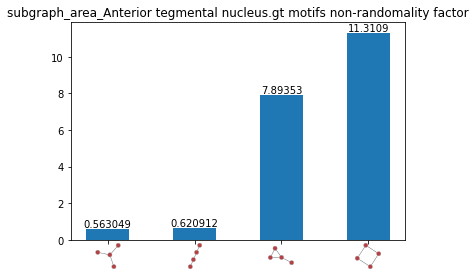

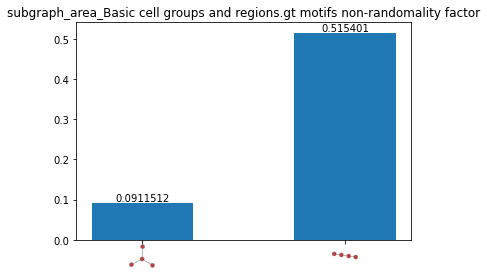

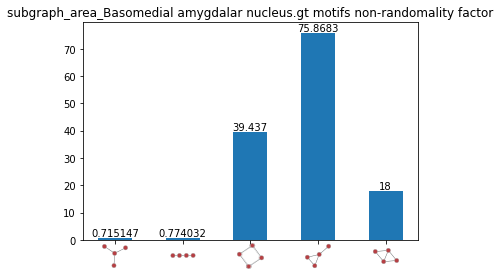

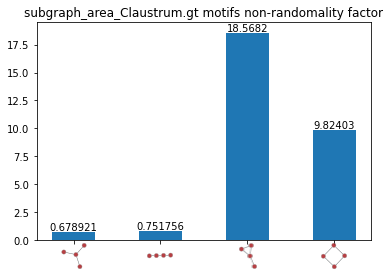

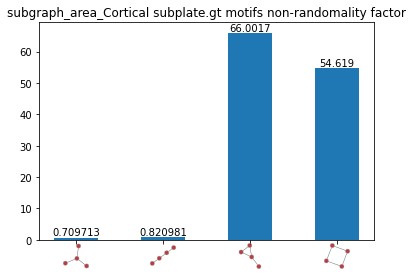

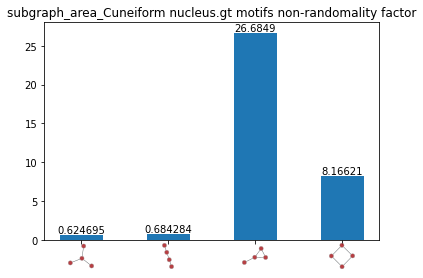

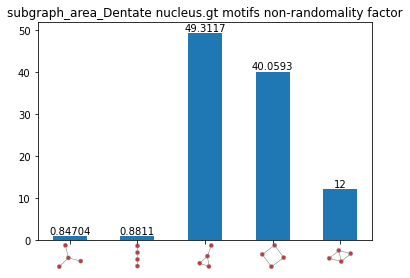

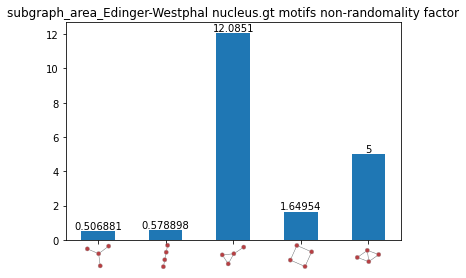

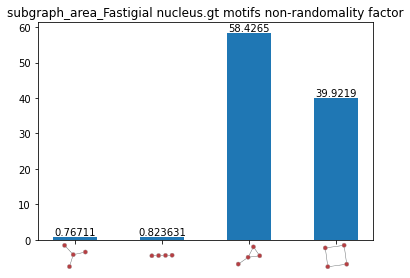

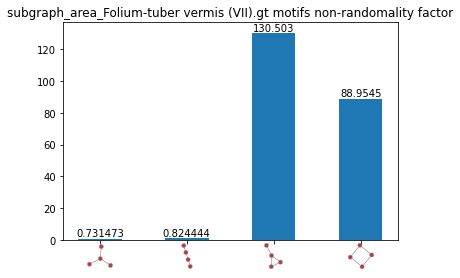

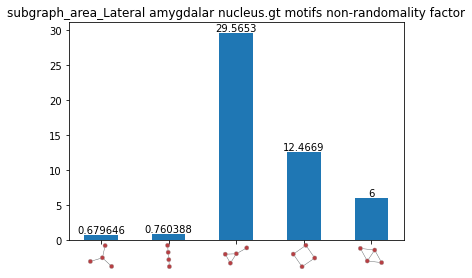

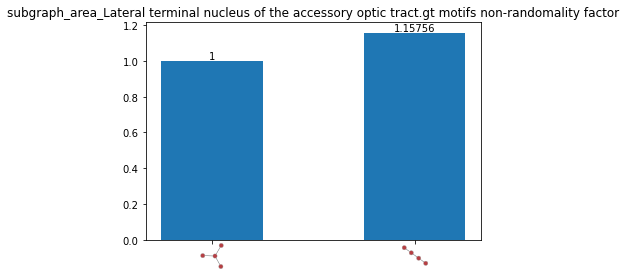

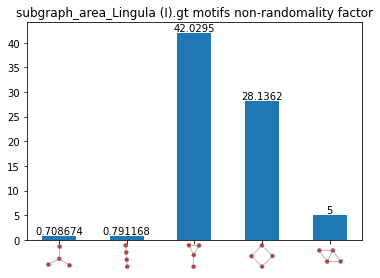

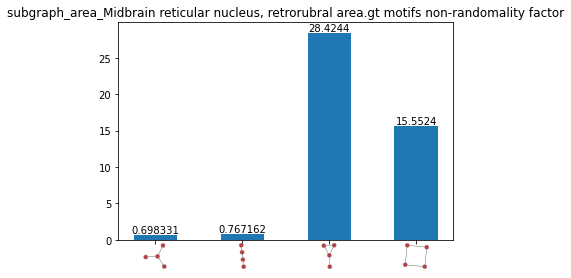

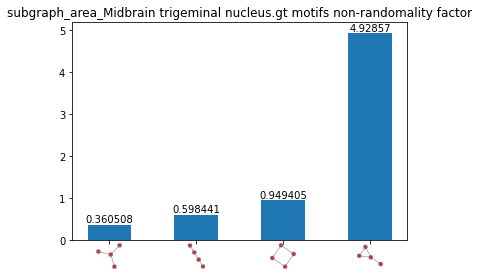

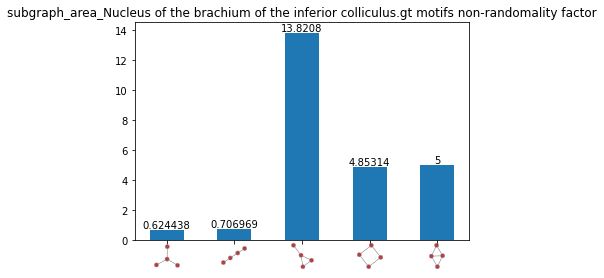

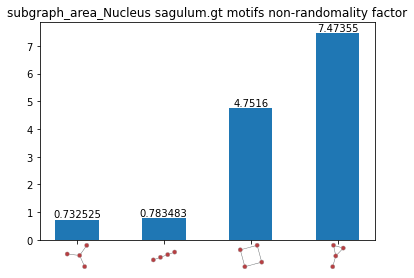

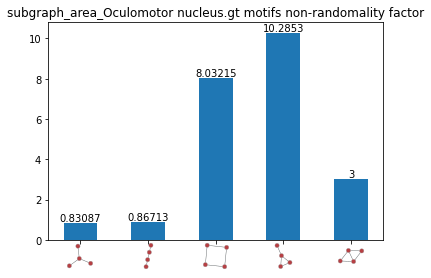

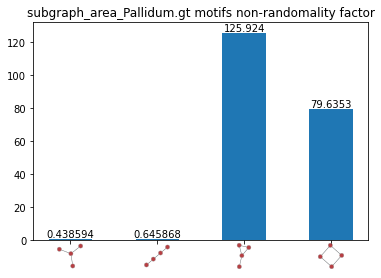

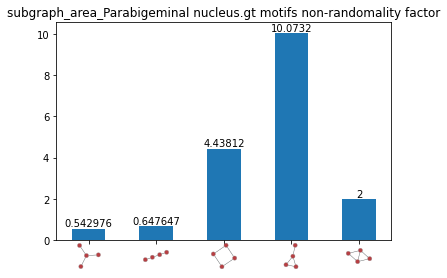

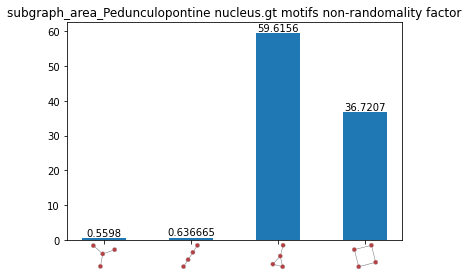

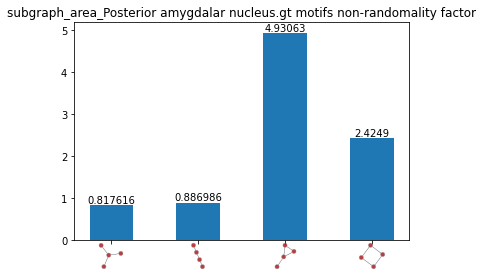

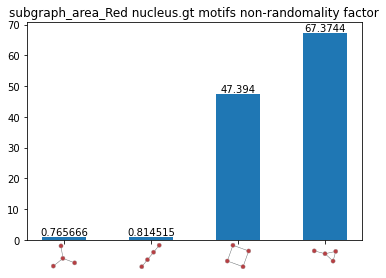

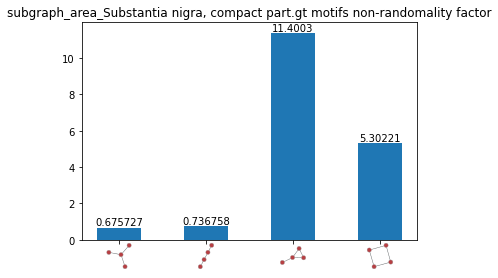

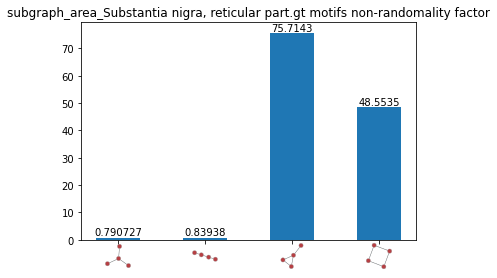

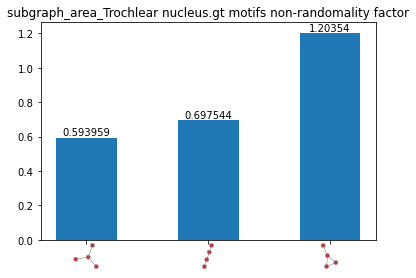

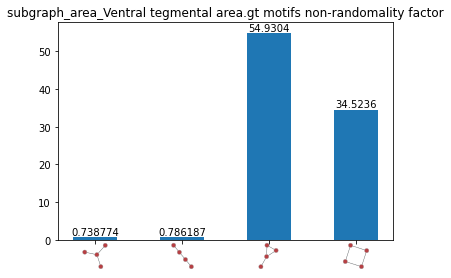

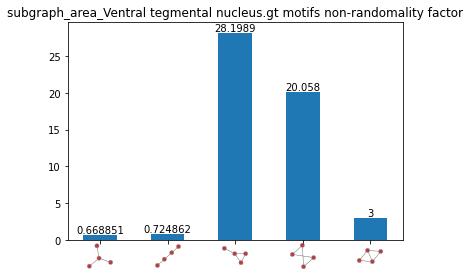

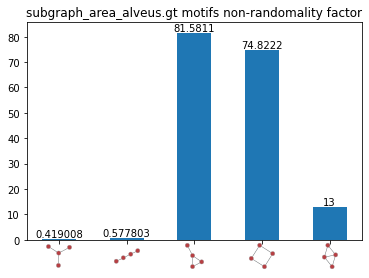

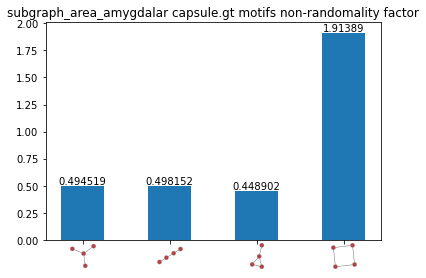

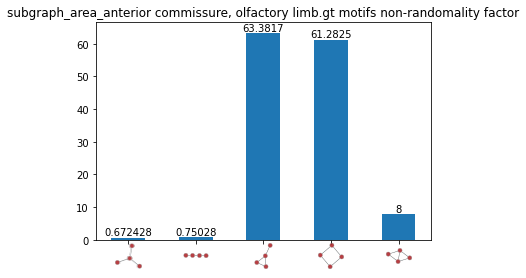

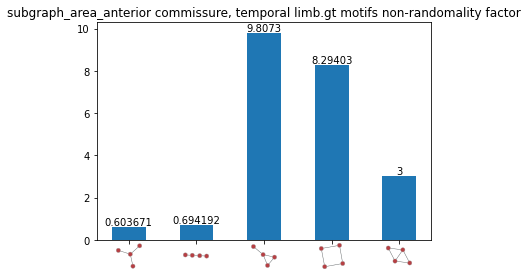

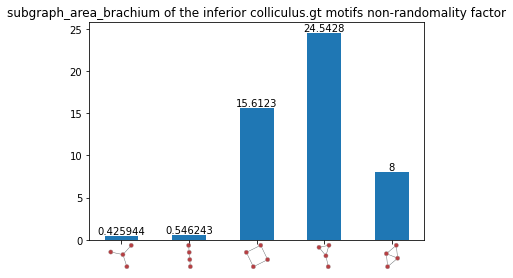

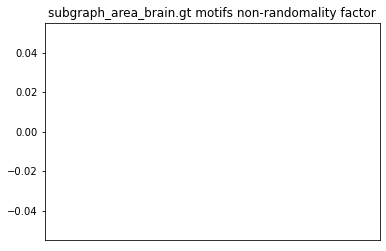

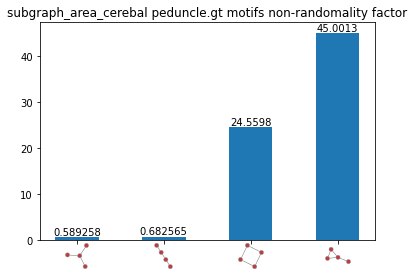

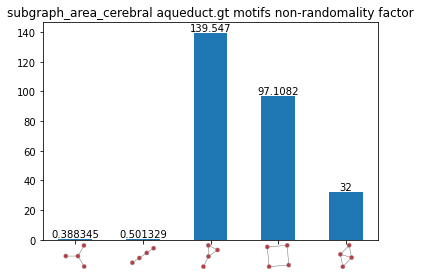

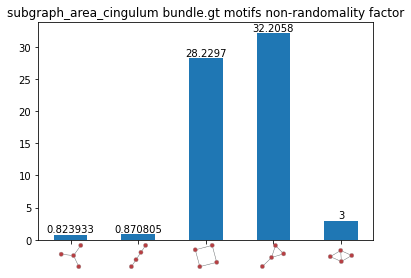

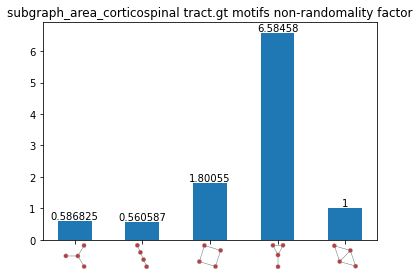

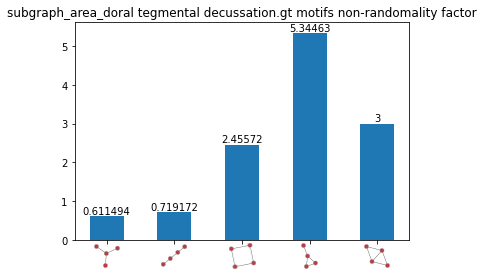

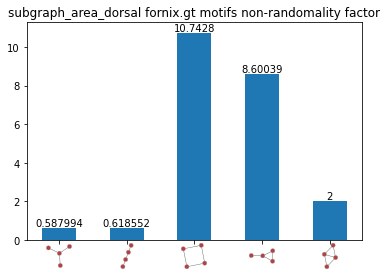

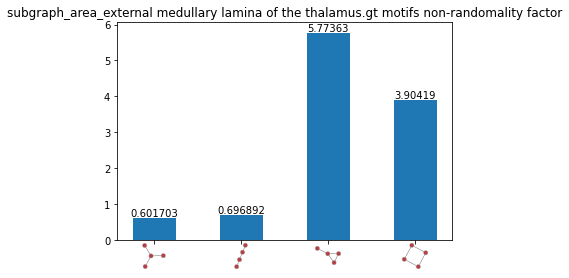

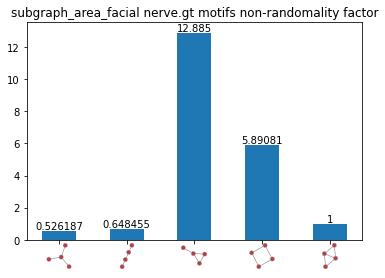

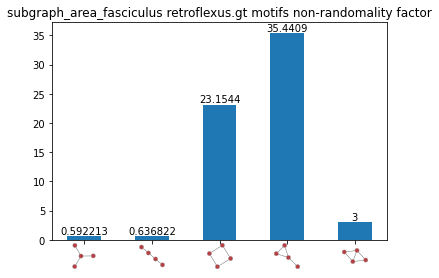

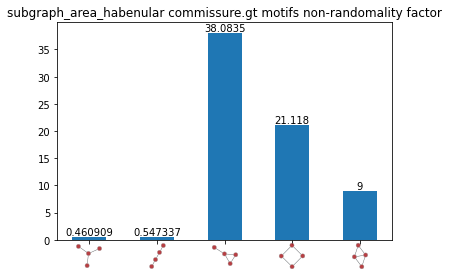

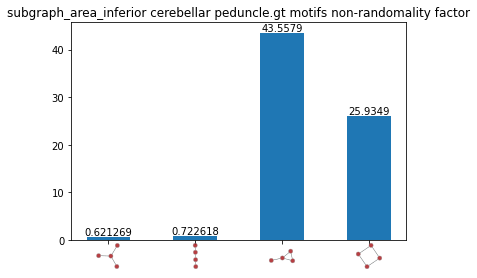

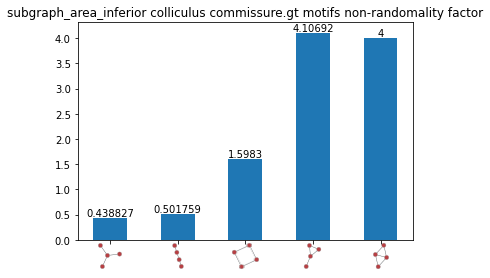

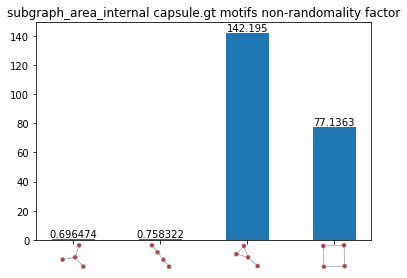

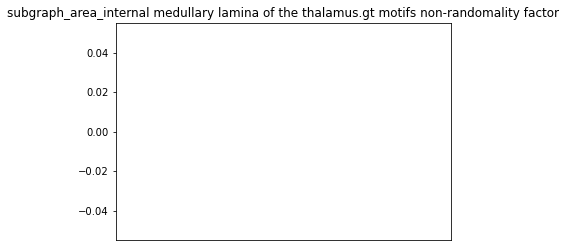

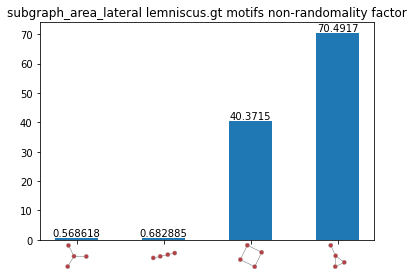

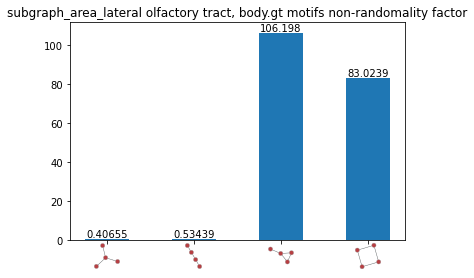

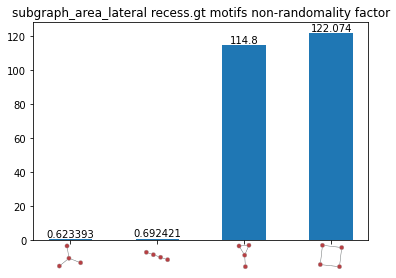

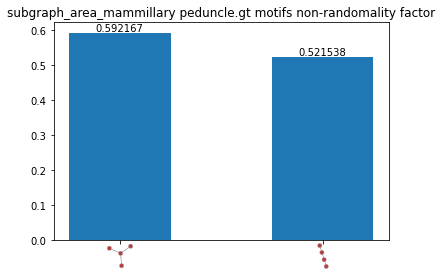

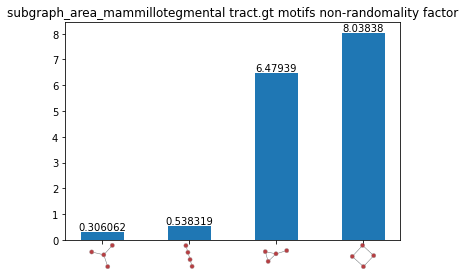

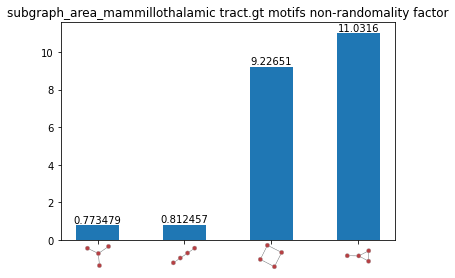

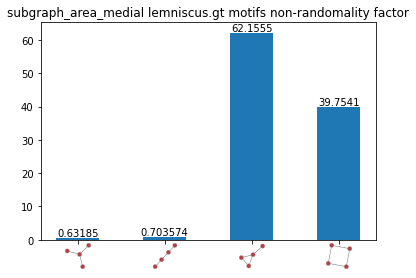

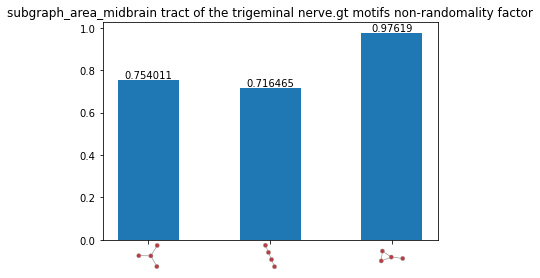

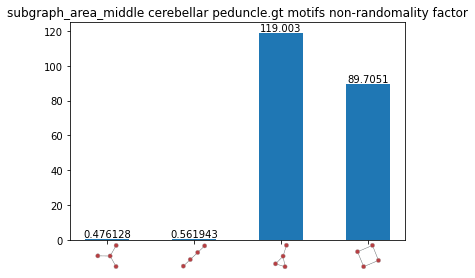

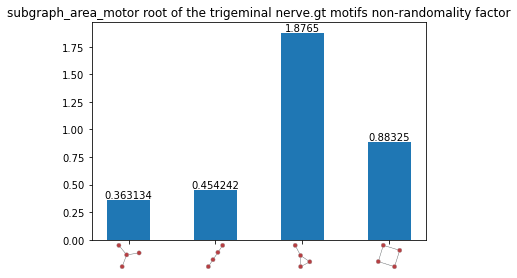

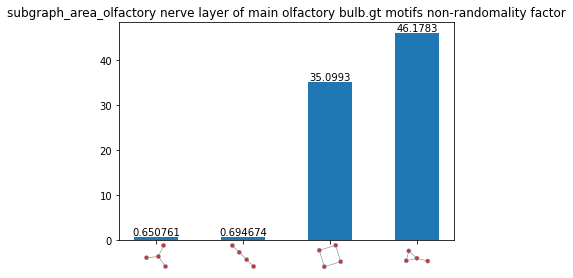

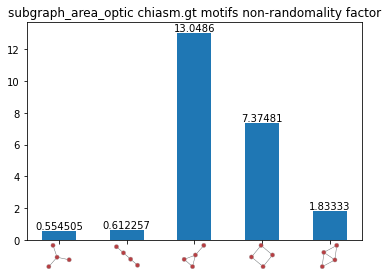

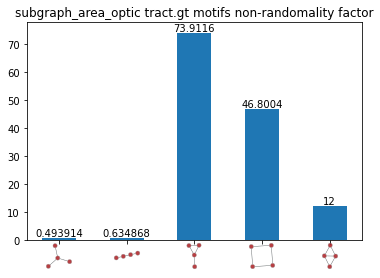

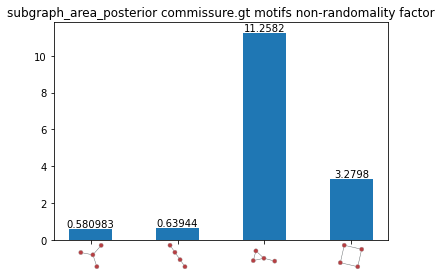

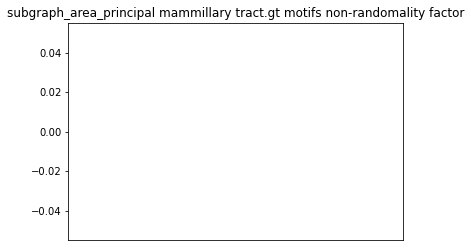

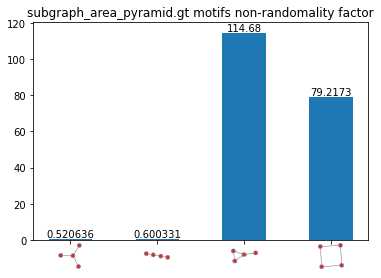

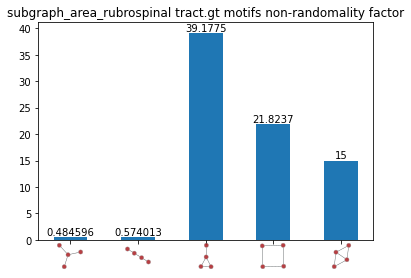

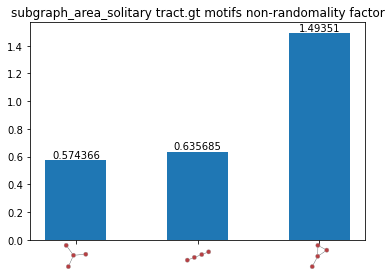

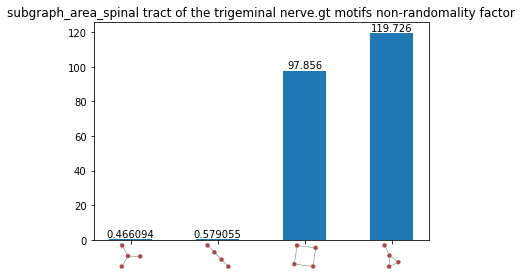

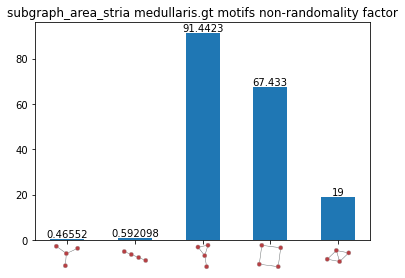

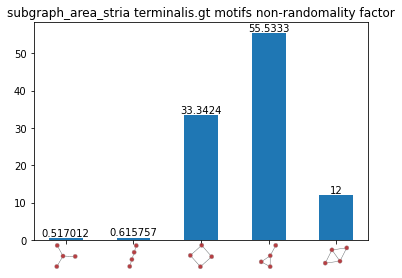

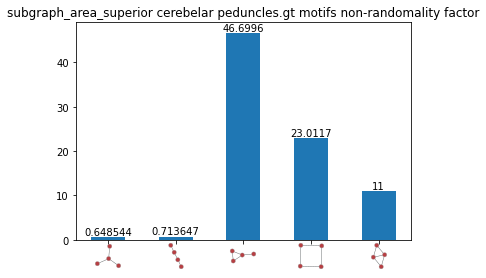

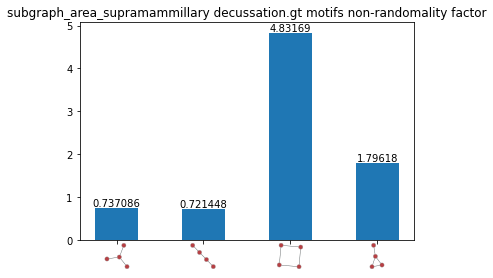

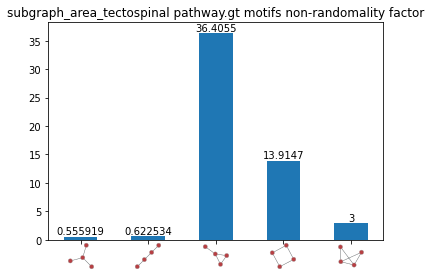

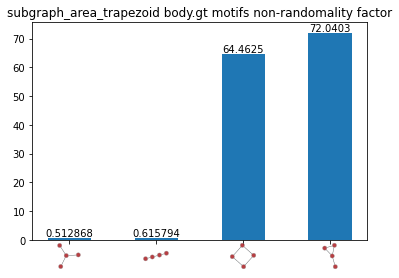

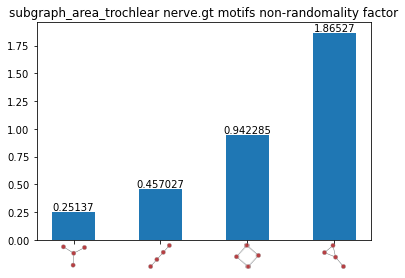

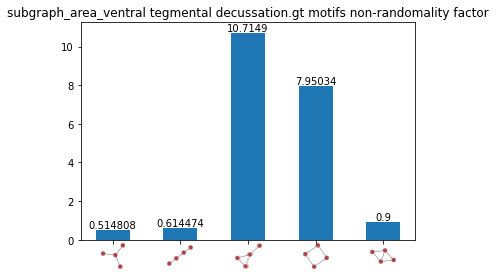

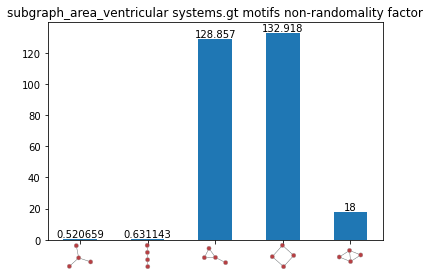

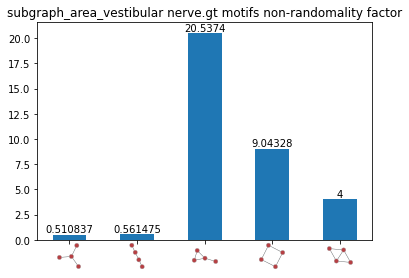

In [9]:
subgraphs_dir = '/scratch/mice_subgraphs/subgraphsByAnnotationLabels'

subgraphs_names = os.listdir(subgraphs_dir)

path_to_save_plots_dir = f'/home/yishaiaz/SubgraphsMotifsResults/MiceSubgraphsResults/MotifsNonRandomalityFactorsByAnnotation/shufflesNum_{non_randomality_shuffles_num}/MotifSize_{motifs_len}'

os.makedirs(path_to_save_plots_dir, exist_ok=True)
sorted_subgraph_names = list(sorted(subgraphs_names))

for subgraph_name in sorted_subgraph_names[:]:
    print(subgraph_name)    

    path_to_non_randomallity_info_dir = f'/scratch/motifsDistributions/NonRandomalityFactor/shufflesNum_{non_randomality_shuffles_num}/motifSize_{motifs_len}'
    path_to_motif_non_randomallity_info = os.path.join(path_to_non_randomallity_info_dir,
                                                       f'{subgraph_name}_motifsLen_{motifs_len}_non_randomality_factor_pickle')
    if not os.path.isfile(path_to_motif_non_randomallity_info):
        continue
        
    with open(path_to_motif_non_randomallity_info, 'rb') as f:
        motif_non_randomallity_info = pickle.load(f)
        print(len(motif_non_randomallity_info))
        plot_non_randomality_factor_per_subgraph(motif_non_randomallity_info,
                                                 subgraph_name, motifs_len=motifs_len, 
                                                 path_to_save_plot_dir=path_to_save_plots_dir)

## Motifs with structural elements 

In [ ]:
from itertools import chain, combinations

motifs_len = 4
subgraphs_dir = '/scratch/mice_subgraphs/subgraphsByAnnotationLabels'
subgraphs_names = os.listdir(subgraphs_dir)
subgraph_name = subgraphs_names[0]
g = load_graph(subgraph_path)
remove_parallel_edges(g)
motifs, motifs_cnts, motifs_vertex_properties = clst.motifs(g, k=motifs_len, p=1.0, return_maps=True)
[v for v in motifs_vertex_properties[0][1]], list(combinations([v for v in motifs_vertex_properties[0][1]], 2))

In [ ]:
from itertools import combinations
from warnings import warn




def get_all_edges_from_vertices_ids(g, motifs_v_ids, collect_properties: Union[None, Dict[str, List[str]]]):
    def collect_properties_helper_func(_g, props_to_collect, ids_to_collect_by, graph_component: str):
        if graph_component != 'v' and graph_component != 'e':
            raise KeyError(f"Supports graph_component value 'v' or 'e' only! got {graph_component}")
        for prop in props_to_collect:
            try:
                prop_map = _g.vp[prop] if graph_component=='v' else _g.ep[prop]
            except KeyError as e:
                warn(f"could not find {'vertex' if graph_component=='v' else 'edge'} property map '{prop}', skipping")
            else:
                motif_prop_values = np.array([prop_map[_id] for _id in ids_to_collect_by])
                if prop_map.value_type() == 'bool':
                    # collect all properties and choose by majority
                    unique, counts = np.unique(motif_prop_values, return_counts=True)
                    motif_prop_rep_val = bool(unique[counts.argmax()])
                elif prop_map.value_type() == 'double':
                    # collect all properties and calc mean
                    motif_prop_rep_val = np.mean(motif_prop_values)
                elif prop_map.value_type().startswith('vector<'):
                    warn(f"Vector properties are not supported yet! recieved {'vertex' if graph_component=='v' else 'edge'} property {prop}")
                motif_properties[f"{graph_component}_{prop}"] = motif_prop_rep_val
                
        return motif_properties
    
    all_possible_edges = list(combinations([v for v in motifs_v_ids], 2))
    all_real_edges = []
    for possible_e in all_possible_edges:
        edge = g.edge(possible_e[0], possible_e[1], all_edges=False, add_missing=False)
        if edge is not None:
            all_real_edges.append(edge)
    # collecting properties if names were provided
    if collect_properties is not None:
        e_props_to_collect, v_props_to_collect = collect_properties['e_props'], collect_properties['v_props']

        motif_properties = {}
        motif_properties.update(collect_properties_helper_func(g, props_to_collect=v_props_to_collect, 
                                                  ids_to_collect_by=motifs_v_ids, graph_component='v'))
        motif_properties.update(collect_properties_helper_func(g, props_to_collect=e_props_to_collect, 
                                                  ids_to_collect_by=all_real_edges, graph_component='e'))

        return all_real_edges, motif_properties
        
    return all_real_edges

    
def find_motif_structural_properties(motif, motif_v_props):
    pass



In [ ]:
motifs_props_to_collect = {
    'v_props' : ['radii', 'artery_binary', 'distance_to_surface', 'coordinates'],
    'e_props' : ['radii', 'artery_binary', 'distance_to_surface', 'coordinates']
}
get_all_edges_from_vertices_ids(g, motifs_vertex_properties[0][1], motifs_props_to_collect)

In [ ]:
prop_map = g.vp['coordinates']
prop_map.value_type()

# Motifs Exploration

In [ ]:
# GRAPH_SSD_PATH = '/scratch/data_graph.gt'
GRAPH_SSD_PATH = '/scratch/yishaiaz@auth.ad.bgu.ac.il/3735255/data_graph.gt'
entire_graph = load_graph(GRAPH_SSD_PATH)

In [ ]:
os.listdir('/scratch/yishaiaz@auth.ad.bgu.ac.il/3735255/data_graph.gt')

In [ ]:
# get a subgraph of specific areas, i.e. filter graph by specific annotation
np.unique(entire_graph.vp['annotation'].a)

In [ ]:
motif_len = 4
motifs, motifs_cnts, motifs_vertex_properties = clst.motifs(entire_graph, k=motif_len, p=1.0, return_maps=True)

In [ ]:
(motifs_vertex_properties[0])

In [ ]:
PREV_RESULTS_DIR = 'GBVasculatureGraphsAnalysis/~/MOTIF_DISTRIBUTIONS_RESULTS'
os.listdir(PREV_RESULTS_DIR)

In [ ]:
with open(os.path.join(PREV_RESULTS_DIR, 'motifs_undirected.pckl'), 'rb') as f:
    motifs = pickle.load(f)
with open(os.path.join(PREV_RESULTS_DIR, 'motifs_cnts_undirected.pckl'), 'rb') as f:
    motifs_cnt = pickle.load(f)
motifs_cnt

In [ ]:
with open(os.path.join(PREV_RESULTS_DIR, 'motifs_vertex_props.pckl'), 'rb') as f:
    motifs_vertex_props = pickle.load(f)
motifs_vertex_props

In [ ]:
from copy import copy, deepcopy

motifs_with_no_redundant_edges = []
motifs_with_no_redundant_edges_cnts = []
motifs_with_no_redundant_edges_properties = []
print('copying motifs and counts')
motifs_cpy = deepcopy(motifs)
motifs_cnt_cpy = deepcopy(motifs_cnt)
motifs_vertex_props_cpy = deepcopy(motifs_vertex_properties)

print('started gathering motifs from copy')
while len(motifs_cpy)>0:
    print(len(motifs_cpy))
    motif1, motif1_cnt, motifs1_props = motifs_cpy[0], motifs_cnt_cpy[0], motifs_vertex_props_cpy[0]
    motif_new_count = motif1_cnt
    combined_motif1_properties = list(motifs1_props)
    for _motif2_idx, _motif2 in enumerate(motifs_cpy[1:]):
        if isomorphism(motif1, _motif2) and motif1 is not _motif2:
            motif_new_count += motifs_cnt_cpy[_motif2_idx]
            combined_motif1_properties += list(motifs_vertex_props_cpy[_motif2_idx])
            del motifs_cpy[_motif2_idx], motifs_cnt_cpy[_motif2_idx], motifs_vertex_props_cpy[_motif2_idx]
    
    motifs_with_no_redundant_edges.append(motif1) 
    motifs_with_no_redundant_edges_cnts.append(motif_new_count)
    motifs_with_no_redundant_edges_properties.append(combined_motif1_properties)
    
    del motifs_cpy[0]
#     _motif1_idx+=1
    
# for motif1, motif1_cnt, motifs1_props in zip(motifs_cpy, motifs_cnt_cpy, motifs_vertex_props_cpy):
#     motif_new_count = motif1_cnt
#     combined_motif1_properties = list(motifs1_props)
#     _motif1_idx += 1
#     for _motif2_idx, _motif2 in enumerate(motifs_cpy):
#         if isomorphism(motif1, _motif2) and motif1 is not _motif2:
#             motif_new_count += motifs_cnt_cpy[_motif2_idx]
#             combined_motif1_properties += list(motifs_vertex_props_cpy[_motif2_idx])
#             del motifs_cpy[_motif2_idx], motifs_cnt_cpy[_motif2_idx], motifs_vertex_props_cpy[_motif2_idx]
            
#     motifs_with_no_redundant_edges.append(motif1) 
#     motifs_with_no_redundant_edges_cnts.append(motif_new_count)
#     motifs_with_no_redundant_edges_properties.append(combined_motif1_properties)
#     motif_no_duplicates = remove_parallel_edges(motif)
#     motifs_with_no_redundant_edges.append(motif_no_duplicates)

In [ ]:
entire_graph.num_vertices(), len(motifs_with_no_redundant_edges_properties)#, motifs_with_no_redundant_edges_cnts, motifs_with_no_redundant_edges_properties[0]


In [ ]:
motifs_with_no_redundant_edges_properties

In [ ]:
motifs_knowledge_dictionary = {
    'motifs_graphs': motifs_with_no_redundant_edges,
    'motifs_counts': motifs_with_no_redundant_edges_cnts, 
    'motifs_properties_maps': motifs_with_no_redundant_edges_properties
}
file_path = os.path.join(PREV_RESULTS_DIR, 'motifs_knowledge_dictionary.pckl')
with open(file_path, 'wb') as file:
    pickle.dump(motifs_knowledge_dictionary, file)

In [ ]:
# [(key, len(item)) for key, item in motifs_knowledge_dictionary.items()]
_v_id = list(motifs_with_no_redundant_edges_properties[0][0])[0]
# entire_graph.vp['annotation'][_v_id]
# entire_graph.vertex(v_id).properties
len(motifs_knowledge_dictionary["motifs_properties_maps"][1])

In [ ]:
c

In [ ]:
file_path = os.path.join(PREV_RESULTS_DIR, 'motifs_cnt_per_annotation_label.pckl')
with open(file_path, 'wb') as file:
    pickle.dump(motifs_cnt_per_annotation_label, file)

In [ ]:
entire_graph.num_vertices()

In [ ]:
motifs_with_no_redundant_edges
motifs_with_no_redundant_edges_cnts

sum_of_all_motifs_counts = sum(motifs_with_no_redundant_edges_cnts)
for motif, motif_cnt in zip(motifs_with_no_redundant_edges, motifs_with_no_redundant_edges_cnts):
    print(f"motif count: {motif_cnt}, fraction of all motifs: {motif_cnt/sum_of_all_motifs_counts}")
    pos = sfdp_layout(motif)
    graph_draw(motif, pos=pos)#, output="graph-draw-sfdp.pdf")